In [3]:
# Imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [26]:
class DataSet:
    '''
    - This class is used to load data from the various .csv files and convert them to pd.DataFrame. 
    - Please feel free to load more .csv files here if you wish to use them. 
    - The init function currently:
        - loads training_files/trades.csv, training_files/stock_list.csv, training_files/stock_prices.csv and supplemental_files/stock_prices.csv
        - Takes the most recently 6 months of data from supplemental_files/stock_prices.csv as a validation set and the rest is addded to training/stock_prices.csv
        - splits the modified training_file/stock_prices.csv into a training set and a test set (defaults to 70% training, 30% test with seed = 42)
    - Any methods that returns data will return a pd.DataFrame.
    '''

    TRAINING_DIRECTORY = "train_files/"
    TEST_DIRECTORY = "example_test_files/"
    SUPPLEMENTAL_DIRECTORY = "supplemental_files/"
    
    def __init__(self, seed = 42, train_size = 0.70):
        self._trades = pd.read_csv(self.TRAINING_DIRECTORY + "trades.csv")
        self._stock_list = pd.read_csv("stock_list.csv")
        
        prices_df = pd.read_csv(self.TRAINING_DIRECTORY + "stock_prices.csv").fillna(0)
        supp_prices_df = pd.read_csv(self.SUPPLEMENTAL_DIRECTORY + "stock_prices.csv").fillna(0)
        extra_training_df = supp_prices_df[supp_prices_df.Date < "2021-06-1"]
        
        self._stock_prices = pd.concat([prices_df, extra_training_df])
        
        X = self._stock_prices.drop(["Target", "RowId"], axis = 1)
        X.set_index(["Date", "SecuritiesCode"], inplace = True)
        y = self._stock_prices["Target"]
        
        x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = train_size, random_state = seed)
        self.X_train = pd.DataFrame(x_train, columns = X.columns)
        self.Y_train = pd.DataFrame(y_train, columns = ["Target"])
       
        stock_prices_d = supp_prices_df[supp_prices_df.Date >= "2021-06-1"]
        self.X_dev = stock_prices_d.drop(["Target", "RowId"], axis = 1)
        self.X_dev.set_index(["Date", "SecuritiesCode"], inplace = True)
        self.Y_dev = stock_prices_d["Target"].to_frame()
       
        self.X_test = pd.DataFrame(x_test, columns = X.columns)
        self.Y_test = pd.DataFrame(y_test, columns = ["Target"])
        
    def stocks(self) -> np.ndarray:
        return self._stock_prices["SecuritiesCode"].unique()
             
    def x_train(self, security = None) -> pd.DataFrame:
        if security is not None:
            return self.X_train[self.X_train["SecuritiesCode"] == security]
        
        return self.X_train
        
    def x_test(self, security = None) -> pd.DataFrame:            
        if security is not None:
            return self.X_test[self.X_test["SecuritiesCode"] == security]            
        
        return self.X_test
    
    def x_dev(self, security = None) -> pd.DataFrame:
        if security is not None:
            return self.X_dev[self.X_dev["SecuritiesCode"] == security]
        
        return self.X_dev
    
    def y_dev(self, security = None) -> pd.DataFrame:
        if security is not None:
            return self.Y_dev[self.Y_dev["SecuritiesCode"] == security]
        
        return self.Y_dev

    def y_train(self, security = None) -> pd.DataFrame:            
        if security is not None:
            return self.Y_train[self.Y_train["SecuritiesCode"] == security]   
        
        return self.Y_train  
            
    def y_test(self, security = None) -> pd.DataFrame:
        if security is not  None:
            return self.Y_test[self.X_test["SecuritiesCode"] == security]
        
        return self.Y_test
        
    def stock_list(self) -> pd.DataFrame:
        return self._stock_list
    
    def trades(self) -> pd.DataFrame:
        return self._trades
    
    def stock_prices(self) -> pd.DataFrame:
        return self._stock_prices

ds = DataSet()

In [ ]:
def plot_stock_price(securities_code):
    df = ds.stock_prices()
    df[df["SecuritiesCode"] == securities_code].plot(x = "Date", y = "Close", figsize=(8,4))
    plt.ylabel("Close")
    plt.title("Close for {}".format(securities_code))
    plt.locator_params(axis='x', nbins=8)
    plt.show()

def plot_stock_target(securities_code):
    df = ds.stock_prices()
    df[df["SecuritiesCode"] == securities_code].plot(x = "Date", y = "Target", figsize=(8,4))
    plt.ylabel("Target")
    plt.title("Target for {}".format(securities_code))
    plt.locator_params(axis='x', nbins=8)
    plt.show()

plot_stock_price(6502)
plot_stock_target(6502)


The best alpha for Ridge Regression is 0.1


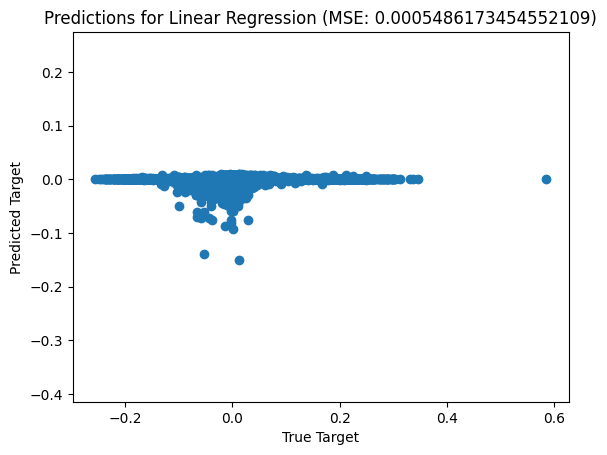

MSE for Linear Regression is 0.0005486173454552109


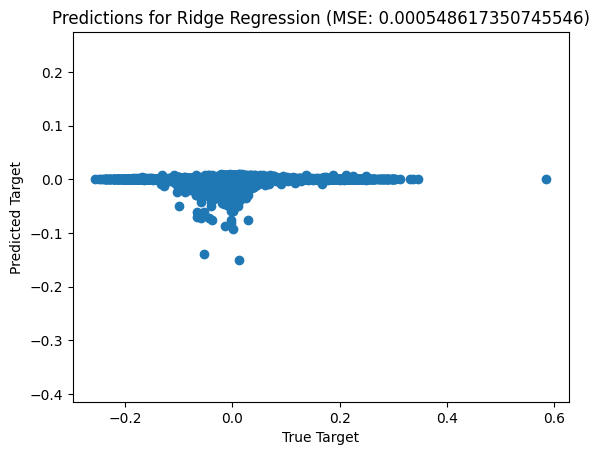

MSE for Ridge Regression is 0.000548617350745546


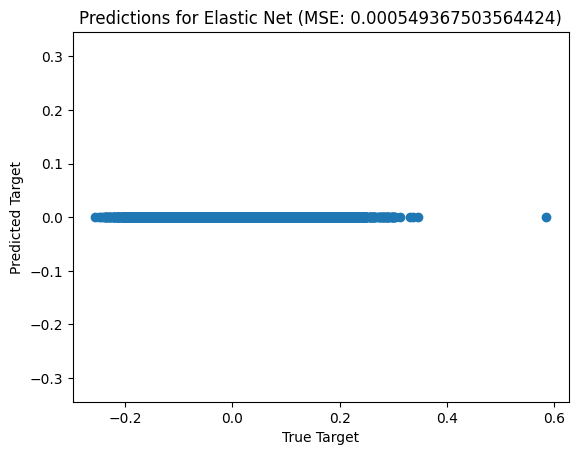

MSE for Elastic Net is 0.000549367503564424


In [28]:
# Matt's Linear Models

class BasicModels:
    def __init__(self):
        self.basic_features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Volume",
            "AdjustmentFactor",
            "ExpectedDividend",
            "SupervisionFlag",
        ]
        self.ds = DataSet()
        self.lr_models = dict()
        self.rg_models = dict()
        self.en_models = dict()
        self.trained = False
        self.split_trained = False
        
    # without splitting the data into each stock
    def run_models(self):
        if self.split_trained:
            return
        
        x_train = self.ds.x_train()[self.basic_features]
        y_train = self.ds.y_train() 
        
        x_dev = self.ds.x_dev()[self.basic_features]
        y_dev = self.ds.y_dev()
        
        cv_alpha = make_pipeline(
            StandardScaler(), 
            RidgeCV(alphas = np.logspace(-6, 6, 13))
        ).fit(x_dev, y_dev).named_steps['ridgecv'].alpha_
        
        print(f"The best alpha for Ridge Regression is {cv_alpha}")
        
        lr_model = make_pipeline(StandardScaler(), LinearRegression()).fit(x_train, y_train)
        rg_model = make_pipeline(StandardScaler(), Ridge(alpha = cv_alpha)).fit(x_train, y_train)
        en_model = make_pipeline(StandardScaler(), ElasticNet()).fit(x_train, y_train)

        def compute_loss(model, model_name):
            x_test = self.ds.x_test() 
            y_test = self.ds.y_test()
            
            y_pred = model.predict(x_test)
            mse = mean_squared_error(y_test, y_pred)
            
            plt.scatter(y_test, y_pred)
            plt.xlabel("True Target")
            plt.ylabel("Predicted Target")
            plt.title("Predictions for {} (MSE: {})".format(model_name, mse))
            plt.axis('equal')
            plt.show()
            
            print("MSE for {} is {}".format(model_name, mse))

        compute_loss(lr_model, "Linear Regression")
        compute_loss(rg_model, "Ridge Regression")
        compute_loss(en_model, "Elastic Net")
               
        
    def plot_results(self):
        for security_code in self.ds.stocks():
            x_test = self.ds.x_test(security_code)
            y_test = self.ds.y_test(security_code)
            
            lr_model = self.rg_models[security_code]
            lr_y_pred = lr_model.predict(x_test)
            
            rg_model = self.rg_models[security_code]
            rg_y_pred = rg_model.predict(x_test)
            
            en_model = self.en_models[security_code]
            en_y_pred = en_model.predict(x_test)
            
            fig, ax = plt.subplots()
            ax.scatter(y_test, lr_y_pred, label = "Linear Regression")
            ax.scatter(y_test, rg_y_pred, label = "Ridge Regression")
            ax.scatter(y_test, en_y_pred, label = "Elastic Net")
            
            ax.legend() 
            
            plt.xlabel("True Target")
            plt.ylabel("Predicted Target")
            plt.title("Predictions for {}".format(security_code))
            plt.axis('equal')
            plt.show()
            return 
        
bm = BasicModels()
bm.run_models()


In [ ]:
# Matt's Decision Tree Models

class RegressionTree:
    def __init__(self):
        self.ds = DataSet()
        
        lowest_mse = float('inf')
        best_depth = 1 
        
        x_train = self.ds.x_train()
        y_train = self.ds.y_train()
        x_validation = self
        
        for depth in range(1, 25):
            dtr = DecisionTreeRegressor(max_depth = depth)
            dtr.fit(self.ds.x_train(), self.ds.y_train())
            
            # * WIP